Sports Reference Scraper - For Advanced Stats

In [ ]:
# installing necessary packages. uncomment if you need to use any


#%pip install scrapy
#%pip install crochet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.7/331.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 4.5 MB/s eta 0:00:00


In [2]:
import scrapy
import numpy as np
import pandas as pd


<!DOCTYPE html>
<html data-version="klecko-" data-root="/home/cbb/build" lang="en" class="no-js" >
<head>
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />
    <link rel="dns-prefetch" href="https://cdn.ssref.net/req/202601281" />
<script>
/* https://docs.osano.com/hc/en-us/articles/22469433444372-Google-Consent-Mode-v2  */
  window.dataLayer = window.dataLayer ||[];
      function gtag(){dataLayer.push(arguments);}
      gtag('consent','default',{
        'ad_storage':'denied',
        'analytics_storage':'denied',
        'ad_user_data':'denied',
        'ad_personalization':'denied',
        'personalization_storage':'denied',
        'functionality_storage':'granted',
        'security_storage':'granted',
        'wait_for_update': 500
      });
      gtag("set", "ads_data_redaction", true);
</script>
<script src="https://cmp.osano.com/16CGnCU8UtNhM14s
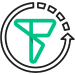
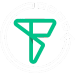

In [3]:
import requests
from scrapy import Selector

url = "https://www.sports-reference.com/cbb/players/sienna-betts-1.html"
html = requests.get(url).text
print(html)

In [4]:
import requests
from scrapy import Selector

url = "https://www.sports-reference.com/cbb/schools/"
html = requests.get(url).text
# print(html)
sel = Selector(text=html)

# 1. Find the wrapper
wrapper = sel.css('#all_NCAAW_schools')

# 2. Try to get the comment inside
comment = wrapper.xpath('comment()').get()

if comment:
    # It was hidden! Clean it.
    clean_html = comment.replace('', '')
    table_sel = Selector(text=clean_html)
    print("Found table in comments. Unwrapping...")
else:
    # It wasn't hidden! Use the wrapper directly.
    table_sel = wrapper
    print("Table was not commented. Reading directly...")

# 3. Extract the links
links_list = [
    f"https://www.sports-reference.com{link}"
    for link in table_sel.css('td[data-stat="school_name"] a::attr(href)').getall()
]

print(links_list)

print(f"Successfully found {len(links_list)} links.")

Table was not commented. Reading directly...
['https://www.sports-reference.com/cbb/schools/abilene-christian/women/', 'https://www.sports-reference.com/cbb/schools/air-force/women/', 'https://www.sports-reference.com/cbb/schools/akron/women/', 'https://www.sports-reference.com/cbb/schools/alabama/women/', 'https://www.sports-reference.com/cbb/schools/alabama-am/women/', 'https://www.sports-reference.com/cbb/schools/alabama-state/women/', 'https://www.sports-reference.com/cbb/schools/albany-ny/women/', 'https://www.sports-reference.com/cbb/schools/alcorn-state/women/', 'https://www.sports-reference.com/cbb/schools/american/women/', 'https://www.sports-reference.com/cbb/schools/appalachian-state/women/', 'https://www.sports-reference.com/cbb/schools/arizona/women/', 'https://www.sports-reference.com/cbb/schools/arizona-state/women/', 'https://www.sports-reference.com/cbb/schools/arkansas/women/', 'https://www.sports-reference.com/cbb/schools/arkansas-state/women/', 'https://www.sports-r

In [16]:
import requests
from scrapy import Selector
import pandas as pd
import re


session = requests.Session()
session.headers.update({
        "User-Agent": (
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        ),
        "Accept-Language": "en-US,en;q=0.9",
})

def get_advanced_stats_df(school_url, year, session, verbose=True):
    season_val = f"{year-1}-{str(year)[-2:]}"

    parts = [p for p in school_url.split('/') if p]
    school_slug = parts[-2] if parts[-1] == 'women' else parts[-1]
    target_url = f"{school_url.rstrip('/')}/{year}.html"

    if verbose:
        print(f"[FETCHING] {target_url}")

    try:
        resp = session.get(target_url, timeout=10)

        if resp.status_code == 429:
            print("[RATE LIMITED]")
            return "BLOCKED"
        if resp.status_code != 200:
            return pd.DataFrame()

        html_content = resp.text

        # ---- REGEX EXTRACT THE ADVANCED TABLE ----
        match = re.search(
            r'(<table[^>]*id="players_advanced"[^>]*>.*?</table>)',
            html_content,
            re.DOTALL
        )

        if not match:
            if verbose:
                print(f"[NO ADV TABLE FOUND] {target_url}")
            return pd.DataFrame()

        table_html = match.group(1)

        # ---- PARSE CLEAN TABLE HTML ----
        sel = Selector(text=table_html)
        rows = sel.css('tbody tr')

        if not rows:
            if verbose:
                print(f"[EMPTY TABLE] {target_url}")
            return pd.DataFrame()

        all_rows = []

        for row in rows:
            if row.css('th[data-stat="ranker"]::text').get() is None:
                continue

            row_data = {
                cell.attrib['data-stat']: cell.css('::text').get()
                for cell in row.css('th, td')
                if 'data-stat' in cell.attrib
            }

            player_link = row.css(
                'td[data-stat="name_display"] a::attr(href)'
            ).get()

            row_data['player_sr_link'] = (
                f"https://www.sports-reference.com{player_link}"
                if player_link else None
            )
            row_data['school'] = school_slug
            row_data['season'] = season_val

            all_rows.append(row_data)

        df = pd.DataFrame(all_rows)

        if df.empty:
            return df

        # ---- CLEANUP ----
        df = df.rename(columns={'name_display': 'player_name'})
        df = df.drop(columns=[c for c in ['ranker', 'awards'] if c in df.columns])

        first_cols = ['player_sr_link', 'player_name', 'school', 'season']
        df = df[first_cols + [c for c in df.columns if c not in first_cols]]

        return df

    except Exception as e:
        if verbose:
            print(f"[ERROR] {e}")
        return pd.DataFrame()


# get_stats_df(links_list[0], 2025)
get_advanced_stats_df(links_list[0], 2025, session)

[FETCHING] https://www.sports-reference.com/cbb/schools/abilene-christian/women/2025.html


,player_sr_link,player_name,school,season,pos,games,games_started,mp,per,ts_pct,...,blk_pct,tov_pct,usg_pct,ows,dws,ws,ws_per_40,obpm,dbpm,bpm
0,https://www.sports-reference.com/cbb/players/b...,Bella Earle,abilene-christian,2024-25,G,34,34,1177,21.3,.521,...,0.9,22.3,23.4,2.9,2.5,5.5,.186,1.8,0.7,2.5
1,https://www.sports-reference.com/cbb/players/e...,Emma Troxell,abilene-christian,2024-25,F,34,34,1078,16.2,.531,...,0.2,14.9,18.3,2.6,1.8,4.4,.162,0.9,-0.5,0.5
2,https://www.sports-reference.com/cbb/players/m...,Meredith Mayes,abilene-christian,2024-25,C,32,32,910,25.3,.599,...,5.0,16.6,18.8,3.1,1.9,5.0,.221,3.1,0.1,3.2
3,https://www.sports-reference.com/cbb/players/b...,Breanna Davis,abilene-christian,2024-25,G,35,20,770,10.9,.522,...,0.8,23.7,17.7,1.1,1.0,2.1,.107,-3.5,-1.4,-4.9
4,https://www.sports-reference.com/cbb/players/p...,Payton Hull,abilene-christian,2024-25,G,22,21,710,25.3,.572,...,1.4,17.6,29.6,2.8,1.2,4.0,.225,4.6,0.0,4.5
5,https://www.sports-reference.com/cbb/players/e...,Erin Woodson,abilene-christian,2024-25,G,29,14,645,18.4,.549,...,0.6,13.2,18.4,1.9,1.1,3.0,.185,1.4,0.3,1.7
6,https://www.sports-reference.com/cbb/players/n...,Natalia Chavez,abilene-christian,2024-25,G,35,3,501,11.5,.447,...,1.3,11.3,17.5,0.8,0.7,1.4,.114,-0.8,-1.6,-2.4
7,https://www.sports-reference.com/cbb/players/m...,Mia Rivers,abilene-christian,2024-25,G,18,16,428,14.2,.439,...,1.2,24.6,18.1,0.3,1.0,1.3,.122,-1.1,3.7,2.6
8,https://www.sports-reference.com/cbb/players/p...,Paula Pique,abilene-christian,2024-25,G,32,1,260,5.6,.442,...,1.0,28.1,14.9,0.0,0.4,0.3,.051,-5.0,-1.5,-6.5
9,https://www.sports-reference.com/cbb/players/z...,Zoe Jackson,abilene-christian,2024-25,G,19,0,254,8.9,.582,...,0.5,37.6,13.9,0.1,0.3,0.5,.072,-1.6,-1.3,-2.9


In [12]:
import os
import time

import os
import time

def scrape_multi_year_data(urls, years_list, base_folder="data"):
    # Safety catch for single strings
    if isinstance(urls, str):
        urls = [urls]

    # Reverse the years list to go in reverse chronological order
    years_to_scrape = sorted(years_list, reverse=True)

    for year in years_to_scrape:
        # Create year folder (only if not exists)
        year_folder = os.path.join(base_folder, str(year))
        os.makedirs(year_folder, exist_ok=True)

        print(f"========== STARTING YEAR: {year} ==========")

        for url_idx, url in enumerate(urls):
            # Extract school slug
            parts = [p for p in url.split('/') if p]
            school_slug = parts[-2] if parts[-1] == 'women' else parts[-1]

            print(f"[{year}] Processing {url_idx + 1}/{len(urls)}: {school_slug}")

            # Fetch the data
            result = get_advanced_stats_df(url, year, session)

            # Block detection
            if isinstance(result, str) and result == "BLOCKED":
                print(f"!!! BLOCKED !!! Stopped at {school_slug} in {year}. Restart later.")
                return

            if not result.empty:
                # Path: data/2026/school_slug_wbb_2026.csv
                filename = f"{school_slug}_wbb_advanced_{year}.csv"
                file_path = os.path.join(year_folder, filename)

                # to_csv defaults to overwriting the file
                result.to_csv(file_path, index=False)
                print(f"      Saved: {file_path}")
            else:
                print(f"      No data found for {year}.")

            # The 4-second "Polite Scraper" delay
            time.sleep(4)

        print(f"========== COMPLETED YEAR: {year} ==========\n")

    print("Scrape complete.")

In [14]:
my_years = [2025, 2026]
scrape_multi_year_data(links_list, my_years)

========== STARTING YEAR: 2026 ==========
[2026] Processing 1/380: abilene-christian
[FETCHING] https://www.sports-reference.com/cbb/schools/abilene-christian/women/2026.html
      Saved: data/2026/abilene-christian_wbb_advanced_2026.csv
[2026] Processing 2/380: air-force
[FETCHING] https://www.sports-reference.com/cbb/schools/air-force/women/2026.html
      Saved: data/2026/air-force_wbb_advanced_2026.csv
[2026] Processing 3/380: akron
[FETCHING] https://www.sports-reference.com/cbb/schools/akron/women/2026.html
      Saved: data/2026/akron_wbb_advanced_2026.csv
[2026] Processing 4/380: alabama
[FETCHING] https://www.sports-reference.com/cbb/schools/alabama/women/2026.html
      Saved: data/2026/alabama_wbb_advanced_2026.csv
[2026] Processing 5/380: alabama-am
[FETCHING] https://www.sports-reference.com/cbb/schools/alabama-am/women/2026.html
      Saved: data/2026/alabama-am_wbb_advanced_2026.csv
[2026] Processing 6/380: alabama-state
[FETCHING] https://www.sports-reference.com/cbb/sc

In [15]:
!zip -r /content/WBBAdvanced25_26.zip /content/data

  adding: content/data/ (stored 0%)
  adding: content/data/2026/ (stored 0%)
  adding: content/data/2026/iona_wbb_advanced_2026.csv (deflated 60%)
  adding: content/data/2026/northeastern_wbb_advanced_2026.csv (deflated 61%)
  adding: content/data/2026/memphis_wbb_advanced_2026.csv (deflated 60%)
  adding: content/data/2026/missouri-state_wbb_advanced_2026.csv (deflated 63%)
  adding: content/data/2026/southern-illinois_wbb_advanced_2026.csv (deflated 62%)
  adding: content/data/2026/florida-state_wbb_advanced_2026.csv (deflated 60%)
  adding: content/data/2026/indiana-state_wbb_advanced_2026.csv (deflated 62%)
  adding: content/data/2026/murray-state_wbb_advanced_2026.csv (deflated 60%)
  adding: content/data/2026/oral-roberts_wbb_advanced_2026.csv (deflated 61%)
  adding: content/data/2026/new-haven_wbb_advanced_2026.csv (deflated 63%)
  adding: content/data/2026/california-baptist_wbb_advanced_2026.csv (deflated 63%)
  adding: content/data/2026/oregon_wbb_advanced_2026.csv (deflated

In [ ]:
my_years = [2022, 2023, 2024]
scrape_multi_year_data(links_list, my_years)

========== STARTING YEAR: 2024 ==========
[2024] Processing 1/380: abilene-christian
      Saved: data\2024\abilene-christian_wbb_2024.csv
[2024] Processing 2/380: air-force
      Saved: data\2024\air-force_wbb_2024.csv
[2024] Processing 3/380: akron
      Saved: data\2024\akron_wbb_2024.csv
[2024] Processing 4/380: alabama
      Saved: data\2024\alabama_wbb_2024.csv
[2024] Processing 5/380: alabama-am
      Saved: data\2024\alabama-am_wbb_2024.csv
[2024] Processing 6/380: alabama-state
      Saved: data\2024\alabama-state_wbb_2024.csv
[2024] Processing 7/380: albany-ny
      Saved: data\2024\albany-ny_wbb_2024.csv
[2024] Processing 8/380: alcorn-state
      Saved: data\2024\alcorn-state_wbb_2024.csv
[2024] Processing 9/380: american
      Saved: data\2024\american_wbb_2024.csv
[2024] Processing 10/380: appalachian-state
      Saved: data\2024\appalachian-state_wbb_2024.csv
[2024] Processing 11/380: arizona
      Saved: data\2024\arizona_wbb_2024.csv
[2024] Processing 12/380: arizona-s

In [ ]:
my_years = [2021]
scrape_multi_year_data(links_list, my_years)

========== STARTING YEAR: 2021 ==========
[2021] Processing 1/380: abilene-christian
      Saved: data\2021\abilene-christian_wbb_2021.csv
[2021] Processing 2/380: air-force
      Saved: data\2021\air-force_wbb_2021.csv
[2021] Processing 3/380: akron
      Saved: data\2021\akron_wbb_2021.csv
[2021] Processing 4/380: alabama
      Saved: data\2021\alabama_wbb_2021.csv
[2021] Processing 5/380: alabama-am
      Saved: data\2021\alabama-am_wbb_2021.csv
[2021] Processing 6/380: alabama-state
      Saved: data\2021\alabama-state_wbb_2021.csv
[2021] Processing 7/380: albany-ny
      Saved: data\2021\albany-ny_wbb_2021.csv
[2021] Processing 8/380: alcorn-state
      Saved: data\2021\alcorn-state_wbb_2021.csv
[2021] Processing 9/380: american
      Saved: data\2021\american_wbb_2021.csv
[2021] Processing 10/380: appalachian-state
      Saved: data\2021\appalachian-state_wbb_2021.csv
[2021] Processing 11/380: arizona
      Saved: data\2021\arizona_wbb_2021.csv
[2021] Processing 12/380: arizona-s

In [ ]:
# need to run this still
my_years = [2020]
scrape_multi_year_data(links_list, my_years)

========== STARTING YEAR: 2020 ==========
[2020] Processing 1/380: abilene-christian
      Saved: data\2020\abilene-christian_wbb_2020.csv
[2020] Processing 2/380: air-force
      Saved: data\2020\air-force_wbb_2020.csv
[2020] Processing 3/380: akron
      Saved: data\2020\akron_wbb_2020.csv
[2020] Processing 4/380: alabama
      Saved: data\2020\alabama_wbb_2020.csv
[2020] Processing 5/380: alabama-am
      Saved: data\2020\alabama-am_wbb_2020.csv
[2020] Processing 6/380: alabama-state
      Saved: data\2020\alabama-state_wbb_2020.csv
[2020] Processing 7/380: albany-ny
      Saved: data\2020\albany-ny_wbb_2020.csv
[2020] Processing 8/380: alcorn-state
      Saved: data\2020\alcorn-state_wbb_2020.csv
[2020] Processing 9/380: american
      Saved: data\2020\american_wbb_2020.csv
[2020] Processing 10/380: appalachian-state
      Saved: data\2020\appalachian-state_wbb_2020.csv
[2020] Processing 11/380: arizona
      Saved: data\2020\arizona_wbb_2020.csv
[2020] Processing 12/380: arizona-s

: 

In [ ]:
my_years = [2019]
scrape_multi_year_data(links_list, my_years)

========== STARTING YEAR: 2019 ==========
[2019] Processing 1/380: abilene-christian
      Saved: data\2019\abilene-christian_wbb_2019.csv
[2019] Processing 2/380: air-force
      Saved: data\2019\air-force_wbb_2019.csv
[2019] Processing 3/380: akron
      Saved: data\2019\akron_wbb_2019.csv
[2019] Processing 4/380: alabama
      Saved: data\2019\alabama_wbb_2019.csv
[2019] Processing 5/380: alabama-am
      Saved: data\2019\alabama-am_wbb_2019.csv
[2019] Processing 6/380: alabama-state
      Saved: data\2019\alabama-state_wbb_2019.csv
[2019] Processing 7/380: albany-ny
      Saved: data\2019\albany-ny_wbb_2019.csv
[2019] Processing 8/380: alcorn-state
      Saved: data\2019\alcorn-state_wbb_2019.csv
[2019] Processing 9/380: american
      Saved: data\2019\american_wbb_2019.csv
[2019] Processing 10/380: appalachian-state
      Saved: data\2019\appalachian-state_wbb_2019.csv
[2019] Processing 11/380: arizona
      Saved: data\2019\arizona_wbb_2019.csv
[2019] Processing 12/380: arizona-s

In [ ]:
my_years = [2018]
scrape_multi_year_data(links_list, my_years)

========== STARTING YEAR: 2018 ==========
[2018] Processing 1/380: abilene-christian
      Saved: data\2018\abilene-christian_wbb_2018.csv
[2018] Processing 2/380: air-force
      Saved: data\2018\air-force_wbb_2018.csv
[2018] Processing 3/380: akron
      Saved: data\2018\akron_wbb_2018.csv
[2018] Processing 4/380: alabama
      Saved: data\2018\alabama_wbb_2018.csv
[2018] Processing 5/380: alabama-am
      Saved: data\2018\alabama-am_wbb_2018.csv
[2018] Processing 6/380: alabama-state
      Saved: data\2018\alabama-state_wbb_2018.csv
[2018] Processing 7/380: albany-ny
      Saved: data\2018\albany-ny_wbb_2018.csv
[2018] Processing 8/380: alcorn-state
      Saved: data\2018\alcorn-state_wbb_2018.csv
[2018] Processing 9/380: american
      Saved: data\2018\american_wbb_2018.csv
[2018] Processing 10/380: appalachian-state
      Saved: data\2018\appalachian-state_wbb_2018.csv
[2018] Processing 11/380: arizona
      Saved: data\2018\arizona_wbb_2018.csv
[2018] Processing 12/380: arizona-s

In [ ]:
my_years = [2017]
scrape_multi_year_data(links_list, my_years)

========== STARTING YEAR: 2017 ==========
[2017] Processing 1/380: abilene-christian
      Saved: data\2017\abilene-christian_wbb_2017.csv
[2017] Processing 2/380: air-force
      Saved: data\2017\air-force_wbb_2017.csv
[2017] Processing 3/380: akron
      Saved: data\2017\akron_wbb_2017.csv
[2017] Processing 4/380: alabama
      Saved: data\2017\alabama_wbb_2017.csv
[2017] Processing 5/380: alabama-am
      Saved: data\2017\alabama-am_wbb_2017.csv
[2017] Processing 6/380: alabama-state
      Saved: data\2017\alabama-state_wbb_2017.csv
[2017] Processing 7/380: albany-ny
      Saved: data\2017\albany-ny_wbb_2017.csv
[2017] Processing 8/380: alcorn-state
      Saved: data\2017\alcorn-state_wbb_2017.csv
[2017] Processing 9/380: american
      Saved: data\2017\american_wbb_2017.csv
[2017] Processing 10/380: appalachian-state
      Saved: data\2017\appalachian-state_wbb_2017.csv
[2017] Processing 11/380: arizona
      Saved: data\2017\arizona_wbb_2017.csv
[2017] Processing 12/380: arizona-s